<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 NLinear를 implementation한 깃허브를 참고해서 이해하고 실험에 적용시켜본다 여기서 진행할 실험은<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>
[reference]<br>
https://github.com/cure-lab/LTSF-Linear/blob/main/models/NLinear.py

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-NLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-NLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-NLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-NLinear']

In [17]:
class Model(nn.Module):
    def __init__(self,configs):
        super(Model,self).__init__()
        self.seq_len = int(configs['online-learning-NLinear']['seq_len'])
        self.pred_len = int(configs['online-learning-NLinear']['pred_len'])
        self.channels = int(configs['online-learning-NLinear']['enc_in'])
        self.individual = configs['online-learning-NLinear']['individual']
        self.device = torch.device('cuda:0')
        if self.individual == True:
            self.Linear = nn.ModuleList()
            for i in range(self.channels):
                self.Linear.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear = nn.Linear(self.seq_len,self.pred_len)
    
    def forward(self,x):
        # x는 RNN Layer처럼 하나의 값이 하나의 텐서안에 들어가 있도록 즉 (batch_size,sequence_length,channe)
        seq_last = x[:,-1,:].view(-1,1,1) #.detach() 여기서 detach는 의미가 없어 보인다
        # https://bo-10000.tistory.com/181
        x = (x-seq_last)
        seq_last = seq_last.to(self.device)
        if self.individual == True:
            output = torch.zeros([x.size(0),self.pred_len,x.size(2)],dtype = x.dtype).to(x.device)
            for i in range(self.channels):
                output[:,:,i] = self.Linear[i](x[:,:,i])# 하나의 특성마다 각기 다른 Linear layer에 집어넣어줌
                # 이렇게 인덱싱하면 위에 처럼 linear layer에 넣기 좋게 나온다
            x = output
        else:
            x = self.Linear(x.permute(0,2,1).to(self.device)).permute(0,2,1)
            # Linear layer안에 있는 matrix와 다른 device에 들어있음
        x = x+seq_last
        return x #[Batch, Output length, Channel]

In [18]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).view(-1,1,pred_len).to(device)

In [19]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [20]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-05.


In [21]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [22]:
target.size()

torch.Size([27360, 1, 1])

In [23]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq.permute(0,2,1))
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')       

Adjusting learning rate of group 0 to 9.5000e-06.
smape 0.22114121137092935 %
Adjusting learning rate of group 0 to 9.0250e-06.
smape 0.08738605571231309 %
Adjusting learning rate of group 0 to 8.5737e-06.
smape 0.0819962593840506 %
Adjusting learning rate of group 0 to 8.1451e-06.
smape 0.080344704657518 %
Adjusting learning rate of group 0 to 7.7378e-06.
smape 0.07911784792072495 %
Adjusting learning rate of group 0 to 7.3509e-06.
smape 0.07829209472384979 %
Adjusting learning rate of group 0 to 6.9834e-06.
smape 0.0772723732400435 %
Adjusting learning rate of group 0 to 6.6342e-06.
smape 0.07645726697321992 %
Adjusting learning rate of group 0 to 6.3025e-06.
smape 0.07581832801156585 %
Adjusting learning rate of group 0 to 5.9874e-06.
smape 0.07522296446221689 %
Adjusting learning rate of group 0 to 5.6880e-06.
smape 0.07471560870912689 %
Adjusting learning rate of group 0 to 5.4036e-06.
smape 0.07419852674523456 %
Adjusting learning rate of group 0 to 5.1334e-06.
smape 0.0737839290

In [26]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.0009048666893889389 %
SMAPE 0.0555469540413469 %
SMAPE 0.0007553914855691346 %
SMAPE 0.02283970119606238 %
SMAPE 0.05356208884040825 %
SMAPE 0.05518484028289094 %
SMAPE 0.11630061455070974 %
SMAPE 0.0010707272001297952 %
SMAPE 0.0005429320360406109 %
SMAPE 0.021968294036923908 %
SMAPE 0.060978920955676585 %
SMAPE 0.02112773091357667 %
SMAPE 0.011666506696201395 %
SMAPE 0.07471910427557305 %
SMAPE 0.07609568740008399 %
SMAPE 0.049373454152373604 %
SMAPE 0.029793699708534405 %
SMAPE 0.030614319141022864 %
SMAPE 0.10683514212723821 %
SMAPE 0.018083486414980143 %
SMAPE 0.14034192461986095 %
SMAPE 0.159204273018986 %
SMAPE 0.06204301049001514 %
SMAPE 0.03219533051014878 %
SMAPE 0.01845007936935872 %
SMAPE 0.05541324318619445 %
SMAPE 0.06981112557696179 %
SMAPE 0.07012868544552475 %
SMAPE 0.02769750087463763 %
SMAPE 0.10037112620193511 %
SMAPE 0.08146416093222797 %
SMAPE 0.020342734205769375 %
SMAPE 0.014357900152390357 %
SMAPE 0.048709022521506995 %
SMAPE 0.02215927789802663 %
SMAPE

SMAPE 0.024904171834350564 %
SMAPE 0.0635344494949095 %
SMAPE 0.017209159559570253 %
SMAPE 0.02078453655121848 %
SMAPE 0.03838263830402866 %
SMAPE 0.027249759092228487 %
SMAPE 0.0337619278288912 %
SMAPE 0.038357300392817706 %
SMAPE 0.03228931178455241 %
SMAPE 0.02356370590860024 %
SMAPE 0.0236130487464834 %
SMAPE 0.022619848416070454 %
SMAPE 0.0006645693500573202 %
SMAPE 0.052647049335064366 %
SMAPE 0.019433479130384512 %
SMAPE 0.01603499937482411 %
SMAPE 0.04166210533003323 %
SMAPE 0.009417622259206837 %
SMAPE 0.01577102874580305 %
SMAPE 0.031982694956241176 %
SMAPE 0.02115618612151593 %
SMAPE 0.08086244174046442 %
SMAPE 0.010373781238740776 %
SMAPE 0.013475662512064446 %
SMAPE 0.016125333437230438 %
SMAPE 0.021193693799432367 %
SMAPE 0.021396833370090462 %
SMAPE 0.12094468099530786 %
SMAPE 0.11310940503608435 %
SMAPE 0.08145947108278051 %
SMAPE 0.0008746282059348687 %
SMAPE 0.0135355890088249 %
SMAPE 0.052904067211784415 %
SMAPE 0.056049739476293325 %
SMAPE 5.9735695685958497e-05 %
S

SMAPE 0.1375023447908461 %
SMAPE 0.07006248773541301 %
SMAPE 0.02618818957125768 %
SMAPE 0.0322805902978871 %
SMAPE 0.0735427055042237 %
SMAPE 0.016910991456825286 %
SMAPE 0.03603493556147441 %
SMAPE 0.06039875920396298 %
SMAPE 0.0037215423501493206 %
SMAPE 0.012940824482939204 %
SMAPE 0.048908675205893815 %
SMAPE 0.04956385082914494 %
SMAPE 0.030460144393146038 %
SMAPE 0.032394585461588576 %
SMAPE 0.032620995421893895 %
SMAPE 0.011268662674410734 %
SMAPE 0.09771949396235868 %
SMAPE 0.027447894157376137 %
SMAPE 0.010675533441826701 %
SMAPE 0.037933815096039325 %
SMAPE 0.005734937376473681 %
SMAPE 0.04408331401646137 %
SMAPE 0.049148289690492675 %
SMAPE 0.04978650112752803 %
SMAPE 0.03556787467096001 %
SMAPE 0.06112685252446682 %
SMAPE 0.015794823819305748 %
SMAPE 0.010755548129964154 %
SMAPE 0.0479853161086794 %
SMAPE 0.014840327436104417 %
SMAPE 0.004086039121148133 %
SMAPE 0.007827057921531377 %
SMAPE 0.05502138449810446 %
SMAPE 0.011496058759803418 %
SMAPE 0.019304807370644994 %
SMA

SMAPE 0.005176645429742166 %
SMAPE 0.055851593730039895 %
SMAPE 0.05677313223714009 %
SMAPE 0.03230912410072051 %
SMAPE 0.011021118894859683 %
SMAPE 0.00043836240600114706 %
SMAPE 0.024083370619337074 %
SMAPE 0.004661227852579941 %
SMAPE 0.014430570350668859 %
SMAPE 0.0001499487286054091 %
SMAPE 0.0014151349166127147 %
SMAPE 0.00013639735706760803 %
SMAPE 0.03504265466472134 %
SMAPE 0.043942699034232646 %
SMAPE 0.0430845131049864 %
SMAPE 0.005971691363356513 %
SMAPE 0.016803298858576454 %
SMAPE 0.0316790780343581 %
SMAPE 0.06357914255931973 %
SMAPE 0.07788611156865954 %
SMAPE 0.0179072820028523 %
SMAPE 0.003198602967188435 %
SMAPE 0.06686686357716098 %
SMAPE 0.04856953403213993 %
SMAPE 0.0329116239445284 %
SMAPE 0.07424513204023242 %
SMAPE 0.008333927436979138 %
SMAPE 0.03958292948664166 %
SMAPE 0.04325682847411372 %
SMAPE 0.08423543378012255 %
SMAPE 0.0001601838053488791 %
SMAPE 0.05246006874949671 %
SMAPE 0.05754678713856265 %
SMAPE 0.020244900297257118 %
SMAPE 0.022437486055423506 %

SMAPE 0.03205622130190022 %
SMAPE 0.06539892737055197 %
SMAPE 0.011659513605991378 %
SMAPE 0.004094608014625578 %
SMAPE 0.046894598548533395 %
SMAPE 0.04101861600065604 %
SMAPE 0.00570249350676022 %
SMAPE 0.0038109503866508025 %
SMAPE 0.00725652799155796 %
SMAPE 0.0268229425419122 %
SMAPE 0.04348004626808688 %
SMAPE 0.002606258296630415 %
SMAPE 0.014452134499151725 %
SMAPE 0.07081504998495802 %
SMAPE 0.0002478014526943184 %
SMAPE 0.06613299675518647 %
SMAPE 0.01998154509055894 %
SMAPE 0.013245413822005503 %
SMAPE 0.000694749825001395 %
SMAPE 0.133446900639683 %
SMAPE 0.07336012250743806 %
SMAPE 0.0019066950973325447 %
SMAPE 0.09388637880329043 %
SMAPE 0.004151010381633569 %
SMAPE 0.03455712980940007 %
SMAPE 0.022129272954771295 %
SMAPE 0.032049242639914155 %
SMAPE 0.0015447753680888356 %
SMAPE 0.007756743525533238 %
SMAPE 0.019906976027414203 %
SMAPE 0.00769763276548474 %
SMAPE 0.049923833284992725 %
SMAPE 0.043449339776998386 %
SMAPE 0.025163759448332712 %
SMAPE 0.04309098338126205 %


SMAPE 0.07400056341430172 %
SMAPE 0.0924385612597689 %
SMAPE 0.016201836711843498 %
SMAPE 0.0074422405596124 %
SMAPE 0.02574352416559123 %
SMAPE 0.07576614123536274 %
SMAPE 0.022313493507681414 %
SMAPE 0.03623583939042874 %
SMAPE 0.027163075530552305 %
SMAPE 0.008075477038801182 %
SMAPE 0.06507684121606871 %
SMAPE 0.0018757626238965486 %
SMAPE 0.03764533990761265 %
SMAPE 0.035077058855677024 %
SMAPE 0.013050880028458778 %
SMAPE 0.033914543193532154 %
SMAPE 0.00910876862690202 %
SMAPE 0.006689092762826476 %
SMAPE 0.04582128894980997 %
SMAPE 0.010713912015489768 %
SMAPE 0.040429607761325315 %
SMAPE 0.019581666070735082 %
SMAPE 0.024916098103858527 %
SMAPE 0.019236423075199127 %
SMAPE 0.16364953224547207 %
SMAPE 0.03929214185336605 %
SMAPE 0.007775939655402909 %
SMAPE 0.016456114986795 %
SMAPE 0.04148135436116718 %
SMAPE 0.02234771773510147 %
SMAPE 0.07408578135073185 %
SMAPE 0.012972675969649572 %
SMAPE 0.059834271436557174 %
SMAPE 0.09909559646621346 %
SMAPE 0.02638069400563836 %
SMAPE 

SMAPE 0.02083782633417286 %
SMAPE 0.005341338877542512 %
SMAPE 0.019154759094817564 %
SMAPE 0.053517226915573694 %
SMAPE 0.013852649637556171 %
SMAPE 0.012211086344905198 %
SMAPE 0.07596187671879306 %
SMAPE 0.037148761068237945 %
SMAPE 0.010448884419020033 %
SMAPE 0.018247697968035936 %
SMAPE 0.0010775446604895933 %
SMAPE 0.03314752216101624 %
SMAPE 0.027582543421885933 %
SMAPE 0.007138974777262774 %
SMAPE 0.13278260175138712 %
SMAPE 0.04891034375759772 %
SMAPE 0.013200694411352742 %
SMAPE 0.002039131146574391 %
SMAPE 0.011507220304338261 %
SMAPE 0.014419936036574654 %
SMAPE 0.00023808130337243938 %
SMAPE 0.015022161875094753 %
SMAPE 0.035589763370808214 %
SMAPE 0.032585720997303724 %
SMAPE 0.03963093948550522 %
SMAPE 0.03753950967802666 %
SMAPE 0.0567713295458816 %
SMAPE 0.03914843319216743 %
SMAPE 0.005096670182723528 %
SMAPE 0.0036041888254914056 %
SMAPE 0.008134612584399292 %
SMAPE 0.0013370498762697025 %
SMAPE 0.012831379193812609 %
SMAPE 0.07114938111044466 %
SMAPE 0.007221941292

SMAPE 0.047781544184545055 %
SMAPE 0.06054623576346785 %
SMAPE 0.03204476472456008 %
SMAPE 0.014221172008547 %
SMAPE 0.032317476143362 %
SMAPE 0.023443875179509632 %
SMAPE 0.00030966047758340665 %
SMAPE 0.04347305709961802 %
SMAPE 0.004886131569946883 %
SMAPE 0.056003962410613894 %
SMAPE 0.01974404499924276 %
SMAPE 0.0001293714120436107 %
SMAPE 0.07181965105701238 %
SMAPE 0.07264375791419297 %
SMAPE 0.00828538427958847 %
SMAPE 0.05984905286459252 %
SMAPE 0.03835369093576446 %
SMAPE 0.009986180855776183 %
SMAPE 0.07032028958201408 %
SMAPE 0.054177639773115516 %
SMAPE 0.07066022360231727 %
SMAPE 0.0014397778695212082 %
SMAPE 0.04158925008960068 %
SMAPE 0.08312168583506718 %
SMAPE 0.06305949471425265 %
SMAPE 0.08351494959788397 %
SMAPE 0.022888733670697547 %
SMAPE 0.0067596796125144465 %
SMAPE 0.0013893353356024818 %
SMAPE 0.031237486633472145 %
SMAPE 0.03709047625306994 %
SMAPE 0.0014822368454616708 %
SMAPE 0.016870953084435314 %
SMAPE 0.03438743550213985 %
SMAPE 0.05266747786663473 %
SM

SMAPE 0.04613512908690609 %
SMAPE 0.0827493947581388 %
SMAPE 0.007169297565269517 %
SMAPE 0.031786224484676495 %
SMAPE 0.06707917584571987 %
SMAPE 0.02866900249500759 %
SMAPE 0.09046936105005443 %
SMAPE 0.013625196937937288 %
SMAPE 0.06123323302017525 %
SMAPE 0.000986893580574133 %
SMAPE 0.03287676486070268 %
SMAPE 0.07512575475266203 %
SMAPE 0.019269578129751608 %
SMAPE 0.025133335395366885 %
SMAPE 0.003176001374868065 %
SMAPE 0.05877224757568911 %
SMAPE 0.04648604226531461 %
SMAPE 0.01796510319400113 %
SMAPE 0.05349981144536286 %
SMAPE 0.048819517862284556 %
SMAPE 0.10931663145311177 %
SMAPE 0.03465215122560039 %
SMAPE 0.0679886945290491 %
SMAPE 0.03828559871180914 %
SMAPE 0.005568268425122369 %
SMAPE 0.01627829542849213 %
SMAPE 0.03662728358176537 %
SMAPE 0.030704531440278515 %
SMAPE 0.020203900494379923 %
SMAPE 0.024805133522022516 %
SMAPE 0.0420960265037138 %
SMAPE 0.11947892466560006 %
SMAPE 0.04984907619655132 %
SMAPE 0.08647839108016342 %
SMAPE 0.0027356218977274693 %
SMAPE 0.0

SMAPE 0.040062596439383924 %
SMAPE 0.00820895620927331 %
SMAPE 0.0010966969714587549 %
SMAPE 0.007919583385955775 %
SMAPE 0.030774748738622293 %
SMAPE 0.028761553374351934 %
SMAPE 0.07513121754163876 %
SMAPE 0.04303505885764025 %
SMAPE 0.01783788211469073 %
SMAPE 0.04221321453223936 %
SMAPE 0.01063081067695748 %
SMAPE 3.2456338722397504e-05 %
SMAPE 2.3413689234530466e-05 %
SMAPE 0.08963839698117226 %
SMAPE 0.06636659393552691 %
SMAPE 0.03452076352550648 %
SMAPE 0.1463253723923117 %
SMAPE 0.12839274771977216 %
SMAPE 0.01458086418278981 %
SMAPE 0.07639419683255255 %
SMAPE 0.050023074756609276 %
SMAPE 0.0001972286830351777 %
SMAPE 0.05930519290268421 %
SMAPE 0.05278959427960217 %
SMAPE 0.008920641485019587 %
SMAPE 0.05983111797831953 %
SMAPE 0.05103112326469273 %
SMAPE 0.013110019310261123 %
SMAPE 0.03375870763557032 %
SMAPE 0.009730584934004582 %
SMAPE 0.06664611515589058 %
SMAPE 0.008925121423089877 %
SMAPE 0.03688993971445598 %
SMAPE 0.015132549815461973 %
SMAPE 0.05256950302282348 %
S

SMAPE 0.9218093371018767 %
SMAPE 0.10775103804189712 %
SMAPE 0.13400000729598105 %
SMAPE 0.19872400350868705 %
SMAPE 0.06572606932604685 %
SMAPE 0.3563594401348382 %
SMAPE 0.3057178924791515 %
SMAPE 0.09387988713569939 %
SMAPE 0.37552952440455556 %
SMAPE 0.008334193840710213 %
SMAPE 0.3357619505841285 %
SMAPE 0.7838693568482996 %
SMAPE 0.6682002022862434 %
SMAPE 0.25041185109876096 %
SMAPE 0.11949455959256738 %
SMAPE 0.8188441032543778 %
SMAPE 0.5993286669254303 %
SMAPE 0.3655582850333303 %
SMAPE 0.7731450437568128 %
SMAPE 1.0561040164902806 %
SMAPE 0.4750237283296883 %
SMAPE 0.22263940493576231 %
SMAPE 0.639766956679523 %
SMAPE 0.20276290737092495 %
SMAPE 0.38431506836786866 %
SMAPE 1.0490161385387182 %
SMAPE 1.0784587301313877 %
SMAPE 0.630617521237582 %
SMAPE 0.23550115316174924 %
SMAPE 0.27426045504398644 %
SMAPE 0.20601753098890185 %
SMAPE 0.15377964195795357 %
SMAPE 0.32382054976187646 %
SMAPE 0.013801123743178323 %
SMAPE 0.24569126567803323 %
SMAPE 0.25797105161473155 %
SMAPE 0.

SMAPE 0.5172886699438095 %
SMAPE 0.6755013889633119 %
SMAPE 1.0229353364557028 %
SMAPE 0.8032721579074859 %
SMAPE 0.5109077733941376 %
SMAPE 1.063509359024465 %
SMAPE 0.3357538052368909 %
SMAPE 0.30865616141818464 %
SMAPE 0.7643810561858118 %
SMAPE 0.649193350225687 %
SMAPE 0.7437527035363019 %
SMAPE 0.3388247564435005 %
SMAPE 0.026148895572987385 %
SMAPE 1.2956627057865262 %
SMAPE 1.3671886045485735 %
SMAPE 0.8935286803171039 %
SMAPE 0.4360484289936722 %
SMAPE 0.4273786814883352 %
SMAPE 0.5024641552008688 %
SMAPE 0.21011170512065291 %
SMAPE 0.06420872890157625 %
SMAPE 0.4085054993629456 %
SMAPE 0.03940066852374002 %
SMAPE 0.6286363680846989 %
SMAPE 0.03549885013489984 %
SMAPE 0.4588591060601175 %
SMAPE 0.22340058744885027 %
SMAPE 0.5062885750085115 %
SMAPE 0.3755790248978883 %
SMAPE 0.14648937457241118 %
SMAPE 0.11936138966120781 %
SMAPE 0.8439000956714152 %
SMAPE 0.5568802324123681 %
SMAPE 0.08364249620353803 %
SMAPE 0.1954715404426679 %
SMAPE 0.5819702101871371 %
SMAPE 0.96252612397

SMAPE 0.22899182862602174 %
SMAPE 0.33788362820632756 %
SMAPE 0.5666155954822898 %
SMAPE 0.4451230592094362 %
SMAPE 0.38546029245480895 %
SMAPE 0.09021210559876636 %
SMAPE 0.22591439564712346 %
SMAPE 0.8174727754667401 %
SMAPE 0.9846684709191321 %
SMAPE 1.5098358560353518 %
SMAPE 1.4608080685138702 %
SMAPE 1.0970794884487987 %
SMAPE 1.1748497281223536 %
SMAPE 1.4126772889867425 %
SMAPE 0.8948973175138234 %
SMAPE 0.4113507121801376 %
SMAPE 0.06184935197234154 %
SMAPE 0.07372025749646127 %
SMAPE 0.3477043982129544 %
SMAPE 0.08180544164497405 %
SMAPE 0.2177140444982797 %
SMAPE 0.30573387001641095 %
SMAPE 0.4939150111749768 %
SMAPE 0.16279014199972153 %
SMAPE 0.4267287482507527 %
SMAPE 0.9344202177599072 %
SMAPE 1.010430566035211 %
SMAPE 0.5475993384607136 %
SMAPE 0.39639370306394994 %
SMAPE 0.4936519777402282 %
SMAPE 0.6887244069948792 %
SMAPE 0.4192624120041728 %
SMAPE 0.2885489691980183 %
SMAPE 0.041462116641923785 %
SMAPE 0.7446981729008257 %
SMAPE 0.8097055777907372 %
SMAPE 1.04258253

SMAPE 0.26494121830910444 %
SMAPE 0.19639730243943632 %
SMAPE 0.24987695924937725 %
SMAPE 0.7126046712510288 %
SMAPE 0.5843503293581307 %
SMAPE 0.6127560497261584 %
SMAPE 0.4968063719570637 %
SMAPE 0.10193854145472869 %
SMAPE 0.06933703814866021 %
SMAPE 0.4323604987002909 %
SMAPE 0.6861425284296274 %
SMAPE 0.3069562469609082 %
SMAPE 0.5793398153036833 %
SMAPE 0.540163064841181 %
SMAPE 0.37348093395121396 %
SMAPE 0.048602412949549034 %
SMAPE 0.13782285305205733 %
SMAPE 0.499983498826623 %
SMAPE 0.29946058173663914 %
SMAPE 0.8017022600397469 %
SMAPE 1.0094204749912024 %
SMAPE 0.7347397380508482 %
SMAPE 0.1278101165080443 %
SMAPE 0.4505909630097449 %
SMAPE 0.3516654036939144 %
SMAPE 0.2499239433091134 %
SMAPE 0.2891575638204813 %
SMAPE 0.0007449535308410304 %
SMAPE 0.4690437880344689 %
SMAPE 0.360767716774717 %
SMAPE 0.1683674636296928 %
SMAPE 0.12156692007556558 %
SMAPE 0.05638356867711991 %
SMAPE 0.47939970437437296 %
SMAPE 0.051353675458813086 %
SMAPE 0.11440371512435378 %
SMAPE 0.1848

SMAPE 0.07010638510109857 %
SMAPE 0.25184532231651247 %
SMAPE 0.6136911138892174 %
SMAPE 1.0307405926287174 %
SMAPE 0.43652220582589507 %
SMAPE 0.3085270707961172 %
SMAPE 0.016274379544483963 %
SMAPE 0.03312904865015298 %
SMAPE 0.3907592603936792 %
SMAPE 0.015049148161779156 %
SMAPE 0.08543470012955368 %
SMAPE 0.07557224429911003 %
SMAPE 0.01602656197064789 %
SMAPE 0.041786598158068955 %
SMAPE 0.33286942541599274 %
SMAPE 0.05663646274479107 %
SMAPE 0.0890360040939413 %
SMAPE 0.4132879716344178 %
SMAPE 0.1127275013132021 %
SMAPE 0.597630032338202 %
SMAPE 0.3783882886637002 %
SMAPE 0.5618045926094055 %
SMAPE 0.4799466137774289 %
SMAPE 0.44891769578680396 %
SMAPE 0.3826209914404899 %
SMAPE 0.2930886270478368 %
SMAPE 0.35019433638080955 %
SMAPE 0.12179660669062287 %
SMAPE 0.5747484234161675 %
SMAPE 0.19081679300870746 %
SMAPE 0.21009887824766338 %
SMAPE 1.1740939291194081 %
SMAPE 1.2138428492471576 %
SMAPE 1.090637568384409 %
SMAPE 0.9898411678150296 %
SMAPE 1.4334187870845199 %
SMAPE 1.04

SMAPE 0.6952487714588642 %
SMAPE 0.14153698622249067 %
SMAPE 0.3280171116348356 %
SMAPE 1.1020603748038411 %
SMAPE 2.5055650752037764 %
SMAPE 0.09584999550133944 %
SMAPE 0.40670121740549803 %
SMAPE 0.8004110148176551 %
SMAPE 1.4870946826413274 %
SMAPE 2.0200526379048824 %
SMAPE 0.19888342695776373 %
SMAPE 0.02790705949882977 %
SMAPE 0.3543458883650601 %
SMAPE 0.4428770444355905 %
SMAPE 0.34094493673183024 %
SMAPE 0.3828064438421279 %
SMAPE 0.1290584394009784 %
SMAPE 0.6850176029838622 %
SMAPE 0.9518080148845911 %
SMAPE 0.6453859941102564 %
SMAPE 0.6132224309258163 %
SMAPE 0.32854895293712616 %
SMAPE 0.13593550212681293 %
SMAPE 0.25003408757038414 %
SMAPE 0.32932817935943604 %
SMAPE 0.7198522235266864 %
SMAPE 0.1570399812189862 %
SMAPE 0.0847824661177583 %
SMAPE 0.131114951800555 %
SMAPE 0.19190401735249907 %
SMAPE 0.15081554558128119 %
SMAPE 0.2181204298976809 %
SMAPE 0.22058029961772263 %
SMAPE 0.2835738267749548 %
SMAPE 0.26728591858409345 %
SMAPE 0.1547242111992091 %
SMAPE 0.0760938

SMAPE 0.6644927323795855 %
SMAPE 0.9666720181703568 %
SMAPE 0.10655895911622792 %
SMAPE 0.43604062031954527 %
SMAPE 0.18614920508116484 %
SMAPE 0.09566677315160632 %
SMAPE 0.025823876349022612 %
SMAPE 0.07138520351145416 %
SMAPE 0.30648195347748697 %
SMAPE 0.3745310097001493 %
SMAPE 1.9139780122786763 %
SMAPE 0.49508996540680533 %
SMAPE 0.5820102905854583 %
SMAPE 0.6224391986615956 %
SMAPE 0.7873276229947805 %
SMAPE 1.143811034038663 %
SMAPE 0.7873297110199928 %
SMAPE 0.4153593210503459 %
SMAPE 0.5819860966876149 %
SMAPE 0.35701968194916844 %
SMAPE 1.0481678862124681 %
SMAPE 0.4365910701453686 %
SMAPE 0.06538893969263881 %
SMAPE 0.06447396642761305 %
SMAPE 0.07981070887763053 %
SMAPE 0.27708497969433665 %
SMAPE 0.5967097170650959 %
SMAPE 0.3838995925616473 %
SMAPE 0.09885811840649696 %
SMAPE 0.06811857625143602 %
SMAPE 0.6524841231293976 %
SMAPE 1.4133578073233366 %
SMAPE 0.15094268694519997 %
SMAPE 0.6595095219090581 %
SMAPE 0.1257629405008629 %
SMAPE 0.23895366792567074 %
SMAPE 0.837

SMAPE 0.7761896350421011 %
SMAPE 0.44680804992094636 %
SMAPE 0.10929638170637189 %
SMAPE 0.7111544837243855 %
SMAPE 0.9462189329788089 %
SMAPE 1.0067783342674375 %
SMAPE 0.634628577157855 %
SMAPE 0.7304653208702803 %
SMAPE 1.0512689473107457 %
SMAPE 1.1816483065485954 %
SMAPE 1.0207472192123532 %
SMAPE 0.9350611492991447 %
SMAPE 0.6260441029444337 %
SMAPE 0.587947313208133 %
SMAPE 1.0376705257222056 %
SMAPE 0.7407981683500111 %
SMAPE 0.5173736554570496 %
SMAPE 0.19022484787274152 %
SMAPE 0.3379292245954275 %
SMAPE 0.3949642397928983 %
SMAPE 0.5216169757768512 %
SMAPE 0.5940061989240348 %
SMAPE 0.5802485039457679 %
SMAPE 0.616126537322998 %
SMAPE 0.95622599683702 %
SMAPE 1.1918362993746996 %
SMAPE 1.250300413928926 %
SMAPE 1.1894943676888943 %
SMAPE 0.6295610768720508 %
SMAPE 0.8065621005371213 %
SMAPE 1.1583202667534351 %
SMAPE 0.9689320437610149 %
SMAPE 1.0244438331574202 %
SMAPE 1.0476665077731013 %
SMAPE 1.120697846636176 %
SMAPE 1.11779351439327 %
SMAPE 1.1469137528911233 %
SMAPE 1

SMAPE 0.333635532297194 %
SMAPE 0.13336650282144547 %
SMAPE 0.44399057375267154 %
SMAPE 0.2308865685481578 %
SMAPE 0.05343025480397046 %
SMAPE 0.0019972956015834598 %
SMAPE 0.5414767600595951 %
SMAPE 0.4429762759245932 %
SMAPE 0.6901633236557245 %
SMAPE 0.5986465443857014 %
SMAPE 0.034834831865737215 %
SMAPE 0.08016979246167466 %
SMAPE 0.19426890218164772 %
SMAPE 0.35486140567809343 %
SMAPE 0.4894923986867071 %
SMAPE 0.6936769844032824 %
SMAPE 0.7527972739189863 %
SMAPE 0.5769961974583566 %
SMAPE 0.06616604345617816 %
SMAPE 0.6325160283595324 %
SMAPE 0.3200727035291493 %
SMAPE 0.10868674260564148 %
SMAPE 0.08670319442171603 %
SMAPE 0.15354070020839572 %
SMAPE 0.5434073405340314 %
SMAPE 0.7836014810018243 %
SMAPE 0.37034961860626936 %
SMAPE 0.1336432920070365 %
SMAPE 0.3918132740072906 %
SMAPE 0.11187033576425165 %
SMAPE 0.11230660078581424 %
SMAPE 0.2855389779433608 %
SMAPE 0.4426369154825807 %
SMAPE 0.44192389165982604 %
SMAPE 0.415603220462799 %
SMAPE 0.40792530495673424 %
SMAPE 0.19

SMAPE 0.20353465666994452 %
SMAPE 0.06619490188313648 %
SMAPE 0.3046075801830739 %
SMAPE 0.4697009832598269 %
SMAPE 0.14353858376853168 %
SMAPE 0.13014918053522706 %
SMAPE 0.15052776387892663 %
SMAPE 0.6631311103701591 %
SMAPE 0.7164163822308183 %
SMAPE 3.835064748614059e-05 %
SMAPE 0.26573116960935295 %
SMAPE 0.35881861043162644 %
SMAPE 0.20972746750339866 %
SMAPE 0.1734488985966891 %
SMAPE 0.07175813417416066 %
SMAPE 0.10783751937560739 %
SMAPE 0.15310908679384738 %
SMAPE 0.0018422749521818107 %
SMAPE 0.25000786199234426 %
SMAPE 0.33847064431756735 %
SMAPE 0.5827592113055289 %
SMAPE 0.3833446253556758 %
SMAPE 0.37766999402083457 %
SMAPE 0.05311175872338936 %
SMAPE 0.22899912507273254 %
SMAPE 0.008421260026807431 %
SMAPE 0.15574281639419496 %
SMAPE 0.6307417983189225 %
SMAPE 0.5630577765405178 %
SMAPE 0.27291217795573175 %
SMAPE 0.38344068196602166 %
SMAPE 0.03257779311388731 %
SMAPE 0.44168595457449555 %
SMAPE 0.02231016401492525 %
SMAPE 0.3956088568083942 %
SMAPE 0.14312311250250787

SMAPE 0.5370845943689346 %
SMAPE 0.29364572698250413 %
SMAPE 0.1257244471926242 %
SMAPE 0.48362072044983506 %
SMAPE 0.38496213615871966 %
SMAPE 0.24827708140946922 %
SMAPE 0.22965053212828934 %
SMAPE 0.07085337000899017 %
SMAPE 0.24302461207844317 %
SMAPE 0.09078808431513608 %
SMAPE 0.03543965602875687 %
SMAPE 0.01275310262280982 %
SMAPE 0.3607736653648317 %
SMAPE 0.10057677829172464 %
SMAPE 0.04764552184497006 %
SMAPE 0.3033232113812119 %
SMAPE 0.15536919014994055 %
SMAPE 0.0042690176693156445 %
SMAPE 0.1696622623130679 %
SMAPE 0.3577996587846428 %
SMAPE 0.2035589525476098 %
SMAPE 0.3535604765638709 %
SMAPE 0.62883465224877 %
SMAPE 0.14233123767189682 %
SMAPE 0.2548547484911978 %
SMAPE 0.2553246165625751 %
SMAPE 0.14947091636713594 %
SMAPE 0.2385485363192856 %
SMAPE 0.08280533773358911 %
SMAPE 0.21515275561250746 %
SMAPE 0.16272025206126273 %
SMAPE 0.08342710777651519 %
SMAPE 0.539995837956667 %
SMAPE 0.7097754976712167 %
SMAPE 0.6338654402643442 %
SMAPE 0.6271073049865663 %
SMAPE 0.7

SMAPE 0.12602395960129797 %
SMAPE 0.017752700616256334 %
SMAPE 0.13982083986047655 %
SMAPE 0.18287126917857677 %
SMAPE 0.4123385669663549 %
SMAPE 0.3653083238750696 %
SMAPE 0.22013978473842144 %
SMAPE 0.0001964326232979374 %
SMAPE 0.06442612904356793 %
SMAPE 0.16584937972947955 %
SMAPE 0.1575874238042161 %
SMAPE 0.1875741396797821 %
SMAPE 0.05413303803652524 %
SMAPE 0.11071253113914281 %
SMAPE 0.10397924610879272 %
SMAPE 0.0001486799434076147 %
SMAPE 0.009001212449220475 %
SMAPE 0.05900903441943228 %
SMAPE 0.0880296632531099 %
SMAPE 0.08896059467224404 %
SMAPE 0.09212066401960328 %
SMAPE 0.225827929796651 %
SMAPE 0.1967554190196097 %
SMAPE 0.1264864676631987 %
SMAPE 0.04191906299092807 %
SMAPE 0.12663867173250765 %
SMAPE 0.2404120955616236 %
SMAPE 0.03526178834727034 %
SMAPE 0.01920837289071642 %
SMAPE 0.22386243543587625 %
SMAPE 0.2067057695239782 %
SMAPE 0.10154101939406246 %
SMAPE 0.002464037031792543 %
SMAPE 0.15620417357422411 %
SMAPE 0.16707944974768907 %
SMAPE 0.0019872365700734

SMAPE 0.1611304961843416 %
SMAPE 0.11635652359109372 %
SMAPE 0.18758165289182216 %
SMAPE 0.13628407754004002 %
SMAPE 0.15257902606390417 %
SMAPE 0.06106359814293682 %
SMAPE 0.14449007785879076 %
SMAPE 0.20442587323486805 %
SMAPE 0.22915767855010927 %
SMAPE 0.02605260765994899 %
SMAPE 0.03044101118575782 %
SMAPE 0.2715221776161343 %
SMAPE 0.12521362025290728 %
SMAPE 0.31250448548235 %
SMAPE 0.224850885104388 %
SMAPE 0.09957104793284088 %
SMAPE 0.0693162067909725 %
SMAPE 0.17402853316161782 %
SMAPE 0.005844668443387491 %
SMAPE 0.11393353738822043 %
SMAPE 0.1783189750276506 %
SMAPE 0.13566950627136976 %
SMAPE 0.2294306003022939 %
SMAPE 0.02306896125082858 %
SMAPE 0.006655499539192532 %
SMAPE 0.03806024367804639 %
SMAPE 0.14085625763982534 %
SMAPE 0.2603804967366159 %
SMAPE 0.00021565329724637652 %
SMAPE 0.0063534870805597166 %
SMAPE 0.9184927344322205 %
SMAPE 0.0005630424152371916 %
SMAPE 0.07859079475747421 %
SMAPE 0.3379639636259526 %
SMAPE 0.07042421080404893 %
SMAPE 0.1903838145080953

SMAPE 0.15200189186725765 %
SMAPE 0.009996881271945313 %
SMAPE 0.12876894662622362 %
SMAPE 0.017883181106299162 %
SMAPE 0.029111279611242935 %
SMAPE 0.019481800074572675 %
SMAPE 0.057139827869832516 %
SMAPE 0.08693872444564477 %
SMAPE 0.13609587051905692 %
SMAPE 0.017931303053046577 %
SMAPE 0.061358625593129545 %
SMAPE 0.03868684885674156 %
SMAPE 0.2240914583671838 %
SMAPE 0.057328360388055444 %
SMAPE 0.09762935916660354 %
SMAPE 0.052819079312030226 %
SMAPE 0.018147837938158773 %
SMAPE 0.27275396208278835 %
SMAPE 0.10588935576379299 %
SMAPE 0.1991055780090392 %
SMAPE 0.04161705743172206 %
SMAPE 0.026285216095857322 %
SMAPE 0.04132871757610701 %
SMAPE 0.2171969241462648 %
SMAPE 0.058662379160523415 %
SMAPE 0.0357952362683136 %
SMAPE 0.06077379285125062 %
SMAPE 0.0494302628794685 %
SMAPE 0.058799991034902625 %
SMAPE 0.029253720480483025 %
SMAPE 0.014719788145157509 %
SMAPE 0.06336379761341959 %
SMAPE 0.08257276372751221 %
SMAPE 0.05665782606229186 %
SMAPE 0.08723641553660855 %
SMAPE 0.14

SMAPE 0.0016108301577162365 %
SMAPE 0.003854897899145726 %
SMAPE 0.019306118672830053 %
SMAPE 0.03952295731869526 %
SMAPE 0.01512686068599578 %
SMAPE 0.04855432713520713 %
SMAPE 0.02635809670027811 %
SMAPE 0.11378793837502599 %
SMAPE 0.049982316966634244 %
SMAPE 0.10670326836407186 %
SMAPE 0.05510951724136249 %
SMAPE 0.09995457553304732 %
SMAPE 0.05153190356213599 %
SMAPE 0.09140077483607456 %
SMAPE 0.02321389528515283 %
SMAPE 0.0001082163301830974 %
SMAPE 0.11880358890630305 %
SMAPE 0.05112252707476728 %
SMAPE 0.0036718228075187653 %
SMAPE 0.03041706554358825 %
SMAPE 0.03678073131595738 %
SMAPE 0.0475236642814707 %
SMAPE 0.06178441800875589 %
SMAPE 0.03615594326402061 %
SMAPE 0.022551656642463058 %
SMAPE 0.04914943527546711 %
SMAPE 0.04511918485513888 %
SMAPE 0.06138541863765567 %
SMAPE 0.1392280770232901 %
SMAPE 0.056526278145611286 %
SMAPE 0.09674272657139227 %
SMAPE 0.1383546272991225 %
SMAPE 0.1023014064412564 %
SMAPE 0.08758820395451039 %
SMAPE 0.08997125847963616 %
SMAPE 0.05924

SMAPE 0.03625132323941216 %
SMAPE 0.0016175446288002604 %
SMAPE 0.030722087511094287 %
SMAPE 0.1959639370907098 %
SMAPE 0.002165649529885627 %
SMAPE 0.00463313731506787 %
SMAPE 0.00338490486660703 %
SMAPE 0.04652242091833614 %
SMAPE 0.0022914553367598955 %
SMAPE 0.019901500403648242 %
SMAPE 0.0018686822035718365 %
SMAPE 0.0035962022811304455 %
SMAPE 0.06246777606429533 %
SMAPE 0.03744260981329717 %
SMAPE 0.045738186745438725 %
SMAPE 0.055778219597414136 %
SMAPE 0.06015279603889212 %
SMAPE 0.020792408162378706 %
SMAPE 0.07319441030267626 %
SMAPE 0.0003654918252209427 %
SMAPE 0.004129309316340368 %
SMAPE 0.07410102913854644 %
SMAPE 0.06382624438265339 %
SMAPE 0.027537233967450447 %
SMAPE 0.011371953492925968 %
SMAPE 0.05714855581754819 %
SMAPE 0.04593299122643657 %
SMAPE 0.013155605956853831 %
SMAPE 0.002445063203367681 %
SMAPE 0.0020679056321029066 %
SMAPE 0.08952028374187648 %
SMAPE 0.03356473351595923 %
SMAPE 0.0012831494166931634 %
SMAPE 0.0004115516620402105 %
SMAPE 0.04855149026843

SMAPE 0.054943152295891196 %
SMAPE 0.09384901978773996 %
SMAPE 0.02195780913461931 %
SMAPE 0.10056210862239823 %
SMAPE 0.0027930606504611433 %
SMAPE 0.05539165512891486 %
SMAPE 0.00981135742040351 %
SMAPE 0.018723515924648382 %
SMAPE 0.10838860739022493 %
SMAPE 0.023496672161854804 %
SMAPE 0.011632540896243881 %
SMAPE 0.0005102350432082403 %
SMAPE 0.07176949590211734 %
SMAPE 0.020502884799498133 %
SMAPE 0.0860586108174175 %
SMAPE 0.008876926876837388 %
SMAPE 0.013253701363282744 %
SMAPE 0.031275587825803086 %
SMAPE 0.0032380520196966245 %
SMAPE 0.08244579029269516 %
SMAPE 0.08042392530478537 %
SMAPE 0.040951205242890865 %
SMAPE 0.06917854893254116 %
SMAPE 0.04033720513689332 %
SMAPE 0.06540551444049925 %
SMAPE 0.009299416684370954 %
SMAPE 0.05801686010090634 %
SMAPE 0.06307547190226614 %
SMAPE 0.055082659993786365 %
SMAPE 0.015540423002676105 %
SMAPE 0.03368922870140523 %
SMAPE 0.09243184170918539 %
SMAPE 0.003150637570207948 %
SMAPE 0.050209710636409 %
SMAPE 0.10194525960832833 %
SMAP

SMAPE 0.00028724545882852226 %
SMAPE 0.02658666204661131 %
SMAPE 0.038637313700746745 %
SMAPE 0.009740555426105857 %
SMAPE 0.01365385833196342 %
SMAPE 0.04697914546704851 %
SMAPE 0.03569982835324481 %
SMAPE 0.06794155057286844 %
SMAPE 0.004709333816208527 %
SMAPE 0.03937748703174293 %
SMAPE 0.0474810317682568 %
SMAPE 0.008239038867031923 %
SMAPE 0.002868190804065307 %
SMAPE 0.07052779622608796 %
SMAPE 0.011584134430449922 %
SMAPE 0.02575695283303503 %
SMAPE 0.0009400987071330746 %
SMAPE 0.022939716087421402 %
SMAPE 0.051966796221677214 %
SMAPE 0.025560857888194732 %
SMAPE 0.030829382827505466 %
SMAPE 0.03981414227746427 %
SMAPE 0.009692117884696927 %
SMAPE 0.06343272543745115 %
SMAPE 0.060670576931443065 %
SMAPE 0.09961014275904745 %
SMAPE 0.057178447605110705 %
SMAPE 0.017863807472167537 %
SMAPE 0.10218380950391293 %
SMAPE 0.03002091881353408 %
SMAPE 0.09616723383078352 %
SMAPE 0.07711831294000149 %
SMAPE 0.0017602712759980932 %
SMAPE 0.013973313536553178 %
SMAPE 0.008203785579098621 

SMAPE 0.04297877513454296 %
SMAPE 0.06342558783944696 %
SMAPE 0.0345274263236206 %
SMAPE 0.010160963574890047 %
SMAPE 0.05071312555810437 %
SMAPE 0.04092583357123658 %
SMAPE 0.012332412195974031 %
SMAPE 0.04013692410080694 %
SMAPE 0.06290176202310249 %
SMAPE 0.0232441964908503 %
SMAPE 0.0006839969203085161 %
SMAPE 0.04837922254228033 %
SMAPE 0.025266475829994306 %
SMAPE 0.02891874048509635 %
SMAPE 0.04027399283950217 %
SMAPE 0.06929121678695083 %
SMAPE 0.0022047363819552857 %
SMAPE 0.03410705330315977 %
SMAPE 0.05284819914959371 %
SMAPE 0.037532062036916614 %
SMAPE 0.05093196773668751 %
SMAPE 0.04728080058703199 %
SMAPE 0.05709657876286655 %
SMAPE 0.07527140824822709 %
SMAPE 0.02239117860153783 %
SMAPE 0.08264175453223288 %
SMAPE 0.033761541242711246 %
SMAPE 0.015615840573445894 %
SMAPE 0.00016516609234429325 %
SMAPE 0.010833701759111136 %
SMAPE 0.005833187104144599 %
SMAPE 0.05712062341626734 %
SMAPE 0.0009678689597549806 %
SMAPE 0.036823523172643036 %
SMAPE 0.024748873634962365 %
SMA

SMAPE 0.036360764876008034 %
SMAPE 0.020331565247033723 %
SMAPE 0.06116845342330634 %
SMAPE 0.05950290517648682 %
SMAPE 0.010910758792306297 %
SMAPE 0.0031580347804265325 %
SMAPE 0.04373430597479455 %
SMAPE 0.07280541717773303 %
SMAPE 0.05245373741490767 %
SMAPE 0.023458675903384574 %
SMAPE 0.024911807078751735 %
SMAPE 0.07044379750732332 %
SMAPE 0.05604372394736857 %
SMAPE 0.026234585340716876 %
SMAPE 0.02159801709058229 %
SMAPE 0.04408962355228141 %
SMAPE 0.027654306584736332 %
SMAPE 0.00949667337408755 %
SMAPE 0.055526387877762325 %
SMAPE 0.003678763676361996 %
SMAPE 0.024472821576637216 %
SMAPE 0.048832447500899434 %
SMAPE 0.0318119729636237 %
SMAPE 0.03290610283147544 %
SMAPE 0.06019898672821 %
SMAPE 0.0037907948426436633 %
SMAPE 0.008067142676736694 %
SMAPE 0.012353929232631344 %
SMAPE 0.0684781385352835 %
SMAPE 0.007564668580016587 %
SMAPE 0.00011089196572555693 %
SMAPE 0.10232312406878918 %
SMAPE 0.005201735577429645 %
SMAPE 0.1441663762088865 %
SMAPE 0.061748962383717305 %
SMA

SMAPE 0.06416571617592126 %
SMAPE 0.026050055297673683 %
SMAPE 0.0846714680083096 %
SMAPE 0.01984991670178715 %
SMAPE 0.018429787756758742 %
SMAPE 0.025524518365273252 %
SMAPE 0.011578525824006647 %
SMAPE 0.05851128068752587 %
SMAPE 0.09217207558685914 %
SMAPE 0.028514667123090476 %
SMAPE 0.014876103436108679 %
SMAPE 0.017261837390833534 %
SMAPE 0.07130651408806443 %
SMAPE 0.0108910446651862 %
SMAPE 0.018850427251891233 %
SMAPE 0.014717814992764032 %
SMAPE 0.01000876820035046 %
SMAPE 0.019316079647978768 %
SMAPE 0.0008131273510656456 %
SMAPE 0.04641241696663201 %
SMAPE 0.04668628468061797 %
SMAPE 0.0005176402839239813 %
SMAPE 0.021788632395328023 %
SMAPE 0.022234104937524535 %
SMAPE 0.04465309521765448 %
SMAPE 0.06203783239470794 %
SMAPE 0.012411865536705593 %
SMAPE 0.005933731430559419 %
SMAPE 0.09612466394901276 %
SMAPE 0.00034734296730221104 %
SMAPE 0.038767196267144755 %
SMAPE 0.02420685879769735 %
SMAPE 0.023391932612867095 %
SMAPE 0.06217970611760393 %
SMAPE 0.011788030169554986 

SMAPE 0.0061302279646042734 %
SMAPE 0.03453140414785594 %
SMAPE 0.010478549760591704 %
SMAPE 0.07257847511209548 %
SMAPE 0.0002153115820959783 %
SMAPE 0.012221035583934281 %
SMAPE 0.05813022027723492 %
SMAPE 0.03604044928215444 %
SMAPE 0.014869826816720888 %
SMAPE 0.058663522999268025 %
SMAPE 0.0118521295953542 %
SMAPE 0.019183850032277405 %
SMAPE 0.0693798650172539 %
SMAPE 0.023977462988113984 %
SMAPE 0.04740154731553048 %
SMAPE 0.013540394291339908 %
SMAPE 0.0013627799287831976 %
SMAPE 0.0543174630147405 %
SMAPE 0.006755336664355127 %
SMAPE 0.00035546196910729577 %
SMAPE 0.007056165348330978 %
SMAPE 0.0743925555725582 %
SMAPE 3.148424498533586e-05 %
SMAPE 0.02950002276338637 %
SMAPE 0.005973699629976181 %
SMAPE 0.011203242007468361 %
SMAPE 0.04253296661772765 %
SMAPE 0.01998842286411673 %
SMAPE 0.010696562159864698 %
SMAPE 0.03882589811109938 %
SMAPE 0.0001712079720022075 %
SMAPE 0.0012528242529583622 %
SMAPE 0.03723548704874702 %
SMAPE 0.04801208502613008 %
SMAPE 0.01228750168229453

SMAPE 0.019829027631203644 %
SMAPE 0.023549607620225288 %
SMAPE 0.03028718021232635 %
SMAPE 0.021720275035477243 %
SMAPE 0.05715039803180843 %
SMAPE 0.008786025115114171 %
SMAPE 0.04974025223054923 %
SMAPE 0.001463509577284583 %
SMAPE 0.04936921256012283 %
SMAPE 0.0012507622704447385 %
SMAPE 0.086013704596553 %
SMAPE 0.049503673129947856 %
SMAPE 0.009260537728550844 %
SMAPE 0.009407522451510886 %
SMAPE 0.0017218013633168992 %
SMAPE 0.04468408913817257 %
SMAPE 0.07673269702354446 %
SMAPE 0.017730466366629116 %
SMAPE 0.006774704349481907 %
SMAPE 0.04611807220499031 %
SMAPE 0.0544228185317479 %
SMAPE 0.0033924203081951987 %
SMAPE 0.057206246245186776 %
SMAPE 0.01784401271288516 %
SMAPE 0.003922889296333665 %
SMAPE 0.07065337215317413 %
SMAPE 0.01095894951140508 %
SMAPE 0.03368168667657301 %
SMAPE 0.02500169705308508 %
SMAPE 0.002047166931085087 %
SMAPE 0.024817052137223072 %
SMAPE 0.011245826644881163 %
SMAPE 0.04686484453850426 %
SMAPE 0.08183994679711759 %
SMAPE 0.09099620999768376 %
SM

SMAPE 0.06779549876227975 %
SMAPE 0.02755355002591386 %
SMAPE 0.0013178203166006597 %
SMAPE 0.010796317626954988 %
SMAPE 0.009857204931904562 %
SMAPE 0.011372770826710621 %
SMAPE 0.018526631116401404 %
SMAPE 0.020314708119258285 %
SMAPE 0.08328277163673192 %
SMAPE 4.574044787375442e-05 %
SMAPE 0.05448115800390952 %
SMAPE 0.0534710843639914 %
SMAPE 0.03038298300816678 %
SMAPE 0.016570358464377932 %
SMAPE 0.023007594951195642 %
SMAPE 0.054187314002774656 %
SMAPE 0.012834266031859444 %
SMAPE 0.027816685018478893 %
SMAPE 0.022945424338104203 %
SMAPE 0.00025846085857494927 %
SMAPE 0.007012921655586979 %
SMAPE 0.0010157190304909136 %
SMAPE 0.05396315568941645 %
SMAPE 0.007618055915372678 %
SMAPE 0.05080883775372058 %
SMAPE 0.01605753773037577 %
SMAPE 0.006970429521970799 %
SMAPE 0.04561433783965185 %
SMAPE 0.08195860538398847 %
SMAPE 0.02567238945630379 %
SMAPE 0.02084585078409873 %
SMAPE 0.040308910130988806 %
SMAPE 0.016166777786565945 %
SMAPE 0.008348923984158318 %
SMAPE 0.047277713922085

SMAPE 0.04033503879327327 %
SMAPE 0.018011325504630804 %
SMAPE 0.05408959306078032 %
SMAPE 0.0006745804557084512 %
SMAPE 0.10644456441514195 %
SMAPE 0.03300428902730346 %
SMAPE 0.03940297508961521 %
SMAPE 0.07189952483167872 %
SMAPE 0.028915308037539944 %
SMAPE 0.03278965223580599 %
SMAPE 0.011983415926806629 %
SMAPE 0.022159800078952685 %
SMAPE 0.0010081347654846695 %
SMAPE 0.0666853275615722 %
SMAPE 0.03134082991164178 %
SMAPE 0.046908964664908126 %
SMAPE 0.019635072399978526 %
SMAPE 0.003693538471964075 %
SMAPE 0.00846649654340581 %
SMAPE 0.05085822389810347 %
SMAPE 0.3815518617630005 %
SMAPE 0.24700672389008105 %
SMAPE 0.0078108710076776324 %
SMAPE 0.04303651527152397 %
SMAPE 0.060538828955031924 %
SMAPE 0.030318143079057336 %
SMAPE 0.026625885730027225 %
SMAPE 0.006403438401321182 %
SMAPE 0.05406052223406732 %
SMAPE 0.02719860116485506 %
SMAPE 0.008846696960972622 %
SMAPE 0.07726216543233022 %
SMAPE 0.033394820173271 %
SMAPE 0.019251301579060964 %
SMAPE 0.0027476306469580436 %
SMA

In [27]:
target=list(target.values.reshape(-1))

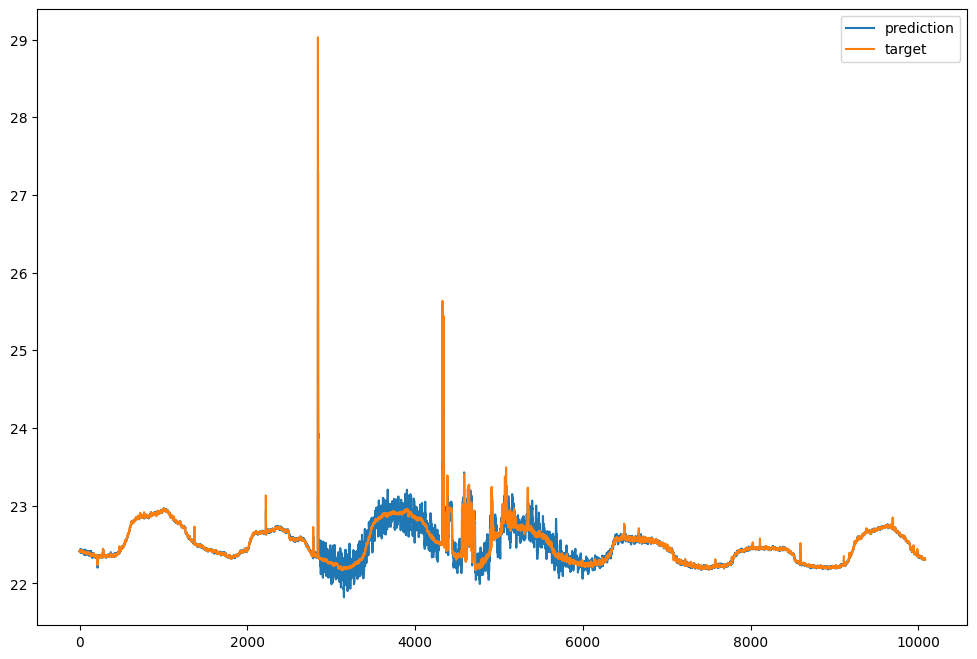

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [29]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.18865524232387543 %


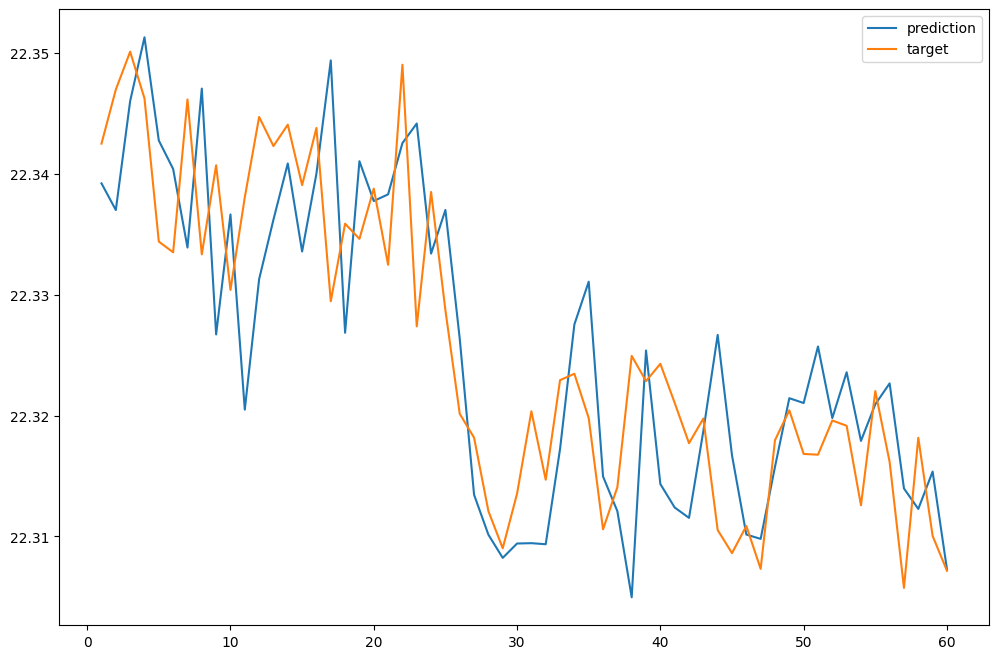

In [30]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [31]:
np.mean(time_list)

0.371413305212581